## error_correction package tutorial
Authors: Gloria Ha and Paul Dieterle

Description: With this package we can infer parameters for different models of error generation in spindle assembly.

Last updated: 4/14/2020

In [1]:
# import packages
from error_correction import data_io
from error_correction import generate_data
from error_correction.model import logLikeIndDelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Model derivation

For this tutorial we will focus on the most basic, "independent model."  We can denote $N$ as the number of chromosomes in each cell.  In this model, each chromosome has an equal low probability, $p$, of missegregation in a single division.  In this case, the probability of $M$ missegregations is given by

\begin{equation*}
    P(M) = {N\choose M}p^M(1-p)^{N-M}.
\end{equation*}

The experimental quantity being measured is the number of chromatids in each daughter cell after a single division. In particular, we are looking to calculate the distribution of *differences* in chromatid counts between the two daughter cells. We assume the $M$ chromosomes that missegregate fall into either daughter cell with equal probability. This gives $Q_1$ full chromosomes in daughter cell 1, meaning that daughter cell 1 has a number of chromatids $N_1$ given by

\begin{equation*}
     N_1 = N-M+2Q_1(M),
\end{equation*}

where $Q_1(M)$ is a random variable distributed according to

\begin{equation*}
     P(Q_1) = {M\choose Q_1}2^{-Q_1}2^{-(M-Q_1)} = {M\choose Q_1}2^{-M}.
\end{equation*}

From this, we can deduce that the distribution of $N_1$ is a simple convolution given by

\begin{equation*}
     P(N_1) = \sum_{M=0}^NP(M)P\left(Q_1 = \frac{N_1-N+M}{2}\right) = \sum_{M=0}^N{N\choose M}{M\choose \frac{N_1-N+M}{2}}2^{-M}p^M(1-p)^{N-M},
\end{equation*}

which tells us as well that the distribution of *differences* in chromatid counts,

\begin{equation*}
    P(\Delta = |N_1-N_2| = 2|N_1-N|),
\end{equation*}

is given by

\begin{equation*}
    P(\Delta) = P(N_1 = N-\Delta/2)+p(N_1=N+\Delta/2).
\end{equation*}

As such, we may construct a beautiful likelihood function given $n$ measurements with measurement $j$ showing chromatid difference $\Delta_j$:

\begin{equation*}
    L(p) = \prod_{n=1}^NP(\Delta_j).
\end{equation*}

Below, we give some demonstrations of this likelihood function with two synthetic datasets. In the future, we need to work to characterize our experimental noise. Of course, there is noise inherent to the biological process and measurement noise in counting chromatids.  We have not incorporated measurement noise in our model yet, as we are still trying to think of its functional form.

We will also use our time to construct other models, including the catastrophe model, in which some large number of chromosomes $C$ missegregate due to a cell-wide coordination mishap.

Let us proceed with our demo.

### Generating synthetic data

With the code in our package, we can generate and store synthetic data for the independent and catastrophe models.  Here we will demonstrate how this data can be generated.  We will start by generating data from the independent model for high and low missegregation probability values.

In [2]:
# set up data directory and parameters
data_dir = 'example_data'
p_misseg = [0.003, 0.01]
n_cells = 1000
n_chrom = 92
p_left = 0.5
p_fn = 0

# generate and store data
high_ind_data = generate_data.GenerateData('independent',
                                          [p_misseg[1], n_cells, n_chrom, p_left, p_fn],
                                          'high_ind',
                                          data_dir)
low_ind_data = generate_data.GenerateData('independent',
                                          [p_misseg[0], n_cells, n_chrom, p_left, p_fn],
                                          'low_ind',
                                          data_dir)

# display snippet of data
print(high_ind_data.data.head())

# display parameters
print(high_ind_data.params)

   errors  N_1  N_2  dNk  N_1_w_noise  N_2_w_noise  dNk_w_noise
0       1   92   94    2           92           94            2
1       0   92   92    0           92           92            0
2       0   92   92    0           92           92            0
3       1   94   92    2           94           92            2
4       2   94   94    0           94           94            0
{'p_misseg': 0.01, 'n_cells': 1000, 'n_chrom': 92, 'p_left': 0.5, 'p_fn': 0}


The `GenerateData` class stores the data in a dataframe and the parameters in a dictionary, as seen above.  The synthetic data includes some information that is hidden in the real data, such as the true number of errors, and the true number of chromatids per cell.

This has also generated two data files per set of parameters, `data_high_ind.txt` and `params_low_ind.yml` in the `example_data` directory, which can then be parsed using the `SyntheticData` class in the `data_io` module.

In [4]:
# let's import the data that we generated
imported_high_ind = data_io.SyntheticData('params_high_ind.yml',
                                          'data_high_ind.txt',
                                          data_dir)
imported_low_ind = data_io.SyntheticData('params_low_ind.yml',
                                         'data_low_ind.txt',
                                         data_dir)
# display snippet of data
print(imported_high_ind.data.head())

# display parameters
print(imported_high_ind.params)

   errors  N_1  N_2  dNk  N_1_w_noise  N_2_w_noise  dNk_w_noise
0       1   92   94    2           92           94            2
1       0   92   92    0           92           92            0
2       0   92   92    0           92           92            0
3       1   94   92    2           94           92            2
4       2   94   94    0           94           94            0
{'n_cells': 1000, 'n_chrom': 92, 'p_fn': 0, 'p_left': 0.5, 'p_misseg': 0.01}


We can see that the information is recovered when we parse the data files. 

### Parameter estimation

Now we can use our log likelihood function derived above to calculate do parameter estimation on the most likely value of the error rate.

In [4]:
# Next, we determine what range of p we would like to examine
p_range = np.linspace(0.001,0.02,20)

# Then, we calculate our likelihoods
like_high = [logLikeIndDelta(imported_high_ind,i) for i in p_range]
like_low = [logLikeIndDelta(imported_low_ind,i) for i in p_range]

Let's plot the results.

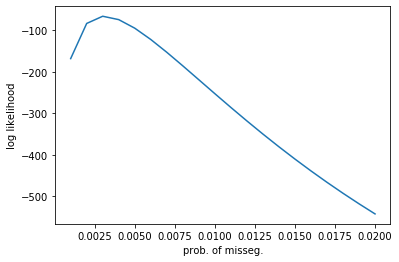

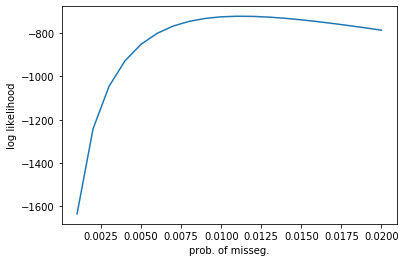

In [5]:
# Then we plot
xl = 'prob. of misseg.'
yl = 'log likelihood'

plt.figure();
plt.plot(p_range,like_low);
plt.xlabel(xl);
plt.ylabel(yl);

plt.figure();
plt.plot(p_range,like_high);
plt.xlabel(xl);
plt.ylabel(yl);

As we can see, these inferred likelihoods indeed agree quite well with the actual values

In [6]:
print(imported_low_ind.params)
print(imported_high_ind.params)

{'n_cells': 1000, 'n_chrom': 92, 'p_fn': 0, 'p_left': 0.5, 'p_misseg': 0.003}
{'n_cells': 1000, 'n_chrom': 92, 'p_fn': 0, 'p_left': 0.5, 'p_misseg': 0.01}
